In [1]:
import matplotlib
matplotlib.use('pgf')

%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pyov2sgd
import time
import pandas as pd

from IPython import display
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from matplotlib.colors import LogNorm

In [2]:
class OCCSVM:

    def __init__(self, gamma=1., nu=0.5, step=1., T=50, D1=500, D2=100, s=10, n_nus=100):
        self.gamma = gamma
        self.step = step
        self.T = T
        self.D1 = D1
        self.D2 = D2
        self.s = s
        self.nu = nu
        self.n_nus = n_nus

    def _predict(self, phiX, theta, B):
        return np.dot(np.dot(phiX, theta), B)
    
    def fit(self, X):
        # INITIALISATION
        scal = StandardScaler()
        scal.fit(X)
        Xs = scal.transform(X)

        phi1 = RBFSampler(gamma=self.gamma, n_components=self.D1, random_state=0)
        phiX1 = phi1.fit_transform(Xs)
        phi2 = RBFSampler(gamma=1. / self.s, n_components=self.D2, random_state=0)

        self._theta1 = np.zeros((self.D1, self.D2))
        self._theta2 = np.zeros(self.D2)
        
        # GRADIENT LEARNING
        for t in range(self.T):
            for nu in np.linspace(-1, 1, self.s):
                rnu = (nu + 1) / 2
                B = phi2.fit_transform(np.array([[nu]]))
                pred = self._predict(phiX1, self._theta1, B.T)
                tau = np.dot(B, self._theta2)
                res = (pred - tau < 0).astype(np.float)
                grad_loss_f = np.dot(np.dot(phiX1.T, -res), B) / X.shape[0]
                grad_reg = rnu * self._theta1
                grad_loss_tau = ((np.mean(res, axis=0) - rnu) * B).ravel()
                self._theta1 = self._theta1 - self.step * (grad_loss_f + grad_reg)
                self._theta2 = self._theta2 - self.step * grad_loss_tau

        # FINALISATION
        self._f = lambda Xt, nu: self._predict(phi1.transform(scal.transform(Xt)), 
                                               self._theta1, 
                                               phi2.transform(nu * 2 - 1).T)
        self._r = lambda nu: np.dot(phi2.transform(nu * 2 - 1), self._theta2)
        
        self._nus = np.linspace(0, 1, self.n_nus).reshape((self.n_nus, 1))
        self._C = np.mean(self._f(X, self._nus) - self._r(self._nus) >= 0, axis=0)
        
        def fs(Xt, split):
            return self._f(Xt, float(self._nus[np.argmax(self._C <= split)]))

        def rs(split):
            return self._r(float(self._nus[np.argmax(self._C <= split)]))

        self._fs = fs
        self._rs = rs
    
    def decision_function(self, Xt, split=None):
        if split is None:
            split = self.nu
        return (self._fs(Xt, 1 - split) - self._rs(1 - split)).ravel()
    
    def predict(self, Xt, split=None):
        return 2 * (self.decision_function(Xt, split) >= 0).astype(np.float) - 1

In [134]:
def generate_cov(p, t='white', **kwargs):
    if t is 'white':
        return kwargs['sigma'] * np.eye(p)
    elif t is 'toeplitz':
        return kwargs['sigma'] ** np.abs(np.arange(p).reshape(-1, 1) - 
                                         np.arange(p).reshape(1, -1))
    else:
        raise Exception('Unknown covariance structure.')
        
def simulate_serie(N, C_noise, W=None, ft='lin', **kwargs):
    p = C_noise.shape[0]
    if W is None:
        W = np.eye(p)
    serie = np.empty((N, p))
    
    serie[0, :] = np.random.multivariate_normal(np.zeros(p), C_noise)
    if ft is 'exp':
        nf = lambda x: np.exp(-kwargs['gamma1'] * x ** 2)
    elif ft is 'sin':
        nf = lambda x: np.sin(-kwargs['period'] * x)
    elif ft is 'lin':
        nf = lambda x: x
    elif ft is 'poly':
        nf = lambda x: x ** 3
    elif ft is 'rff':
        phi = RBFSampler(n_components=1000, gamma=kwargs['gamma2'])
        theta = np.random.randn(1000, 1)
        nf = lambda x: np.dot(np.vstack((phi.fit_transform(x[i].reshape(1, -1)) 
                                         for i in range(p))), theta).ravel()
    else:
        raise Exception('Unknown non linearity function.')
    
    phi = RBFSampler(n_components=1000, gamma=kwargs['gamma2'])
    theta = np.random.randn(1000, p)
    for i in range(1, N):
        serie[i, :] = np.dot(W.T, nf(serie[i - 1, :])) + \
            np.random.multivariate_normal(np.zeros(p), C_noise)

    return serie + 10 * np.dot(phi.fit_transform(
            np.linspace(-1, 1, 1000).reshape(-1, 1)), theta)
        
    

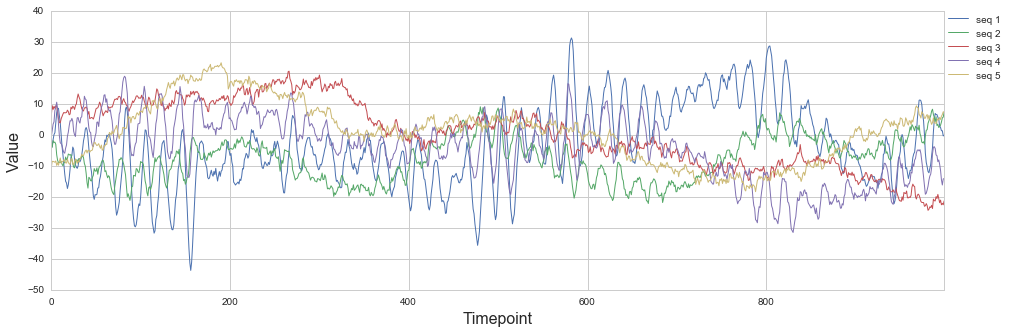

In [135]:
np.random.seed(0)
p = 5
n_interactions = 10

C_noise = generate_cov(p, 'white', sigma=.9)
W = .8 * np.eye(p)
N = 1000
for i in range(n_interactions):
    i1 = 0
    i2 = 0
    while i1 == i2:
        i1 = np.random.randint(p)
        i2 = np.random.randint(p)
    W[i1, i2] = np.random.normal(0, 3 * 1e-1)

serie = simulate_serie(N, C_noise, W=W, ft='lin', gamma1=10., 
                       gamma2=20., period=1.)
pserie = pd.Series(serie.ravel(), 
                   index=pd.MultiIndex.from_product([np.arange(N), 
                                                     np.arange(1, p + 1)], 
                                                    names=['timepoint', 
                                                           'serie']))

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.})
for i in range(1, p + 1):
    pserie[:, i].plot(figsize=(16, 5), alpha=1., 
                      label='seq ' + str(i), legend=True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.ylabel('Value', fontsize=16)
plt.xlabel('Timepoint', fontsize=16)
# plt.savefig('serie_lin_toep.pgf')
plt.show()

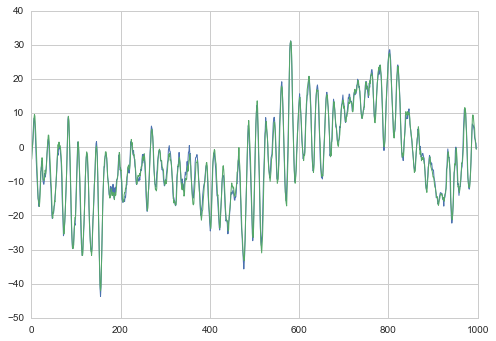

train: 1.567792~0.000000 in 0.012826s
test: 1.858670~0.000000 in 0.012826s


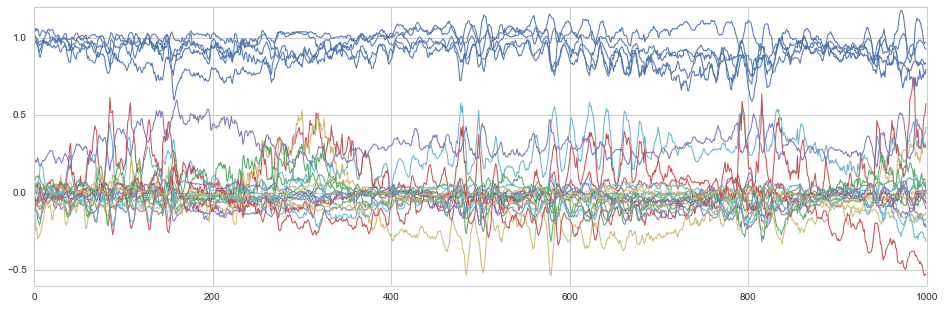

In [145]:
eta0 = 1.
lbda = 0.000001
nu = 0.
block = 25
cond = 1e-10
cap = -1
T = 1
L = pyov2sgd.RidgeLoss()
B = pyov2sgd.DecomposableGaussian(np.eye(p), 40.)
# B = pyov2sgd.DecomposableSkewedChi2(np.eye(p), 20)
C = pyov2sgd.InverseScaling(eta0, 0, 0)

Nw = N - 1
err = np.empty(len(range(Nw, N)))
err_t = np.empty(len(range(Nw, N)))
for (idx, i) in enumerate(range(Nw, N)):
    X = serie[i - Nw    :i - 1, :].copy()
    y = serie[i - Nw + 1:i    , :].copy()
    batch = X.shape[0]

    estimator = pyov2sgd.DSOVK(L, B, C, p, lbda, nu, T, 
                               batch, block, cap, cond)
    start = time.time()
    estimator.fit_dense(X, y)
    stop = time.time()
    pred = estimator.predict_dense(serie[i - 1:i, :])
    err[idx] = np.mean((serie[i, :] - pred) ** 2)
    err_t[idx] = np.mean((serie[i - Nw + 1:i, :] - 
                          estimator.predict_dense(serie[i - Nw:i - 1, :])) ** 2)
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.cla()
plt.plot(serie[i - Nw + 1:i, 0])
plt.plot(estimator.predict_dense(serie[i - Nw:i - 1, :])[:, 0])

display.clear_output(wait=True)
display.display(plt.gcf())
plt.close()
    
print('train: %f~%f in %fs' % (np.mean(err_t), np.std(err_t), stop - start))
print('test: %f~%f in %fs' % (np.mean(err), np.std(err), stop - start))

eps = 1e-10
J = np.zeros((p, p, 1000))
for t in range(1000):
    J[:, :, t] = np.vstack(((estimator.predict_dense(serie[t, :].reshape(1, -1) + eps * np.eye(p)[i, :]) - 
                             estimator.predict_dense(serie[t, :].reshape(1, -1))) / eps for i in range(p)))
    
Xn = J.reshape((J.shape[0] * J.shape[1], J.shape[2])).T.copy()
estimatorJ = OCCSVM(gamma=.01, D2=100)
estimatorJ.fit(Xn)

plt.figure(figsize=(16, 5))
plt.plot(Xn)

In [148]:
serie_n = serie.copy()
noise_idx = np.random.randint(0, serie.shape[0], 50)
# serie_n[noise_idx, :] = serie[noise_idx, :] + 75 / 100 * serie[noise_idx, :]

eps = 1e-10
Jt = np.zeros((p, p, serie_n.shape[0]))
for t in range(serie_n.shape[0]):
    Jt[:, :, t] = np.vstack(((estimator.predict_dense(serie_n[t, :].reshape(1, -1) + eps * np.eye(p)[i, :]) - 
                              estimator.predict_dense(serie_n[t, :].reshape(1, -1))) / eps for i in range(p)))
Xnt = Jt.reshape((Jt.shape[0] * Jt.shape[1], Jt.shape[2])).T.copy()
# serie_n[noise_idx, :] = serie_n[noise_idx, :] + 1

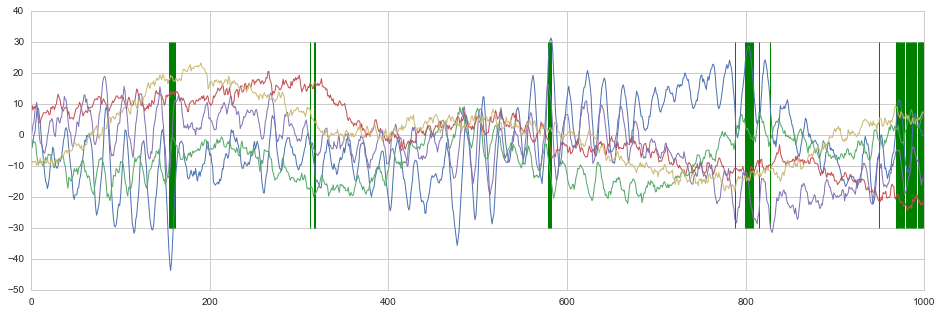

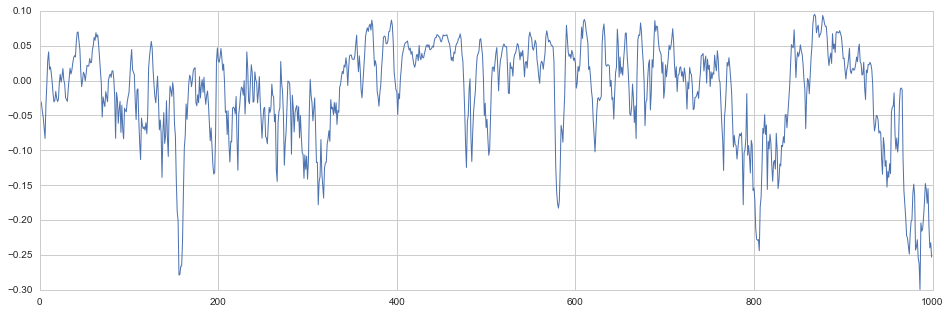

In [149]:
plt.figure(figsize=(16, 5))
plt.plot(serie_n)
# ax = plt.gca()
# plt.vlines(noise_idx, ax.get_ylim()[1] - 10, ax.get_ylim()[1], colors='r')
plt.vlines(np.where(estimatorJ.decision_function(Xnt) < -0.15), ax.get_ylim()[0], ax.get_ylim()[1], colors='g')

plt.figure(figsize=(16, 5))
plt.plot(estimatorJ.decision_function(Xnt))
# plt.figure(figsize=(16, 5))
# plt.plot(serie_n)
# plt.figure(figsize=(16, 5))
# plt.plot(Xn)
# ax = plt.gca()
# plt.vlines(noise_idx, ax.get_ylim()[0], ax.get_ylim()[1], colors='r')
# plt.vlines(np.where(estimatorJ.decision_function(Xnt, split=.02) < 0), ax.get_ylim()[0], ax.get_ylim()[1], colors='g')

In [131]:
estimatorS = OCCSVM(gamma=1., D2=100)
estimatorS.fit(serie)

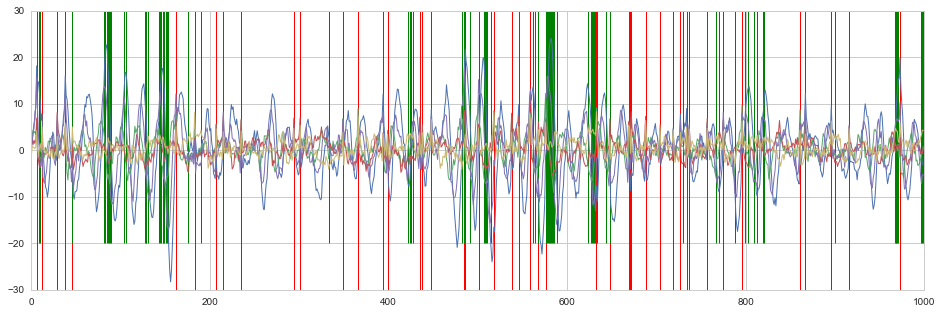

In [58]:
plt.figure(figsize=(16, 5))
plt.plot(serie_n)
ax = plt.gca()
plt.vlines(noise_idx, ax.get_ylim()[0], ax.get_ylim()[1], colors='r')
plt.vlines(np.where(estimatorS.decision_function(serie_n, split=.02) < 0), ax.get_ylim()[0] + 10, ax.get_ylim()[1], colors='g')